In [18]:
"""VNL 2023 Men Analysis Notebook
---------------------------------
Structured workflow: data loading, cleaning, exploration, feature engineering,
modeling, and interpretation.
"""

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.dpi": 110,
    "axes.titlesize": 13,
    "axes.labelsize": 11,
})

# Path resolution: works locally and on Kaggle

candidate_paths = [
    os.environ.get("VNL2023_CSV"),
    "VNL2023.csv",
    os.path.join("data", "VNL2023.csv"),
    "/kaggle/input/vnl-men-2023/VNL2023.csv",
]

csv_path = next((p for p in candidate_paths if p and os.path.exists(p)), None)
if not csv_path:
    error_msg = (
        "VNL2023.csv not found.\n"
        "Local: Place it next to this notebook or in ./data/\n"
        "Kaggle: Add dataset to notebook and ensure path matches /kaggle/input/<dataset-name>/VNL2023.csv"
    )
    raise FileNotFoundError(error_msg)

print("Resolved CSV path:", csv_path)
df_raw = pd.read_csv(csv_path)
print("Raw shape:", df_raw.shape)

df_raw.head()




Resolved CSV path: /kaggle/input/vnl-men-2023/VNL2023.csv
Raw shape: (131, 10)


,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,OH
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,OP
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,OP
3,Herrera Jaime Jesus,Cuba,28,15.00,0.92,1.75,0.00,3.33,0.17,OP
4,Takahashi Ran,Japan,22,11.53,0.67,1.00,0.07,6.40,5.07,OH


In [19]:
# Step 1: Raw data overview
print("Raw shape:", df_raw.shape)
print("Columns:", list(df_raw.columns))

display(df_raw.head(10))
display(df_raw.tail(5))

missing = df_raw.isna().sum().to_frame("missing_count")
missing["missing_pct"] = missing["missing_count"] / len(df_raw)
missing = missing.sort_values("missing_count", ascending=False)
display(missing)

print("Duplicate rows:", df_raw.duplicated().sum())
print("Numeric columns:", df_raw.select_dtypes(include=[np.number]).columns.tolist())
print("Categorical columns:", df_raw.select_dtypes(exclude=[np.number]).columns.tolist())


Raw shape: (131, 10)
Columns: ['Player', 'Country', 'Age', 'Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive', 'Position']


,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,OH
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,OP
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,OP
3,Herrera Jaime Jesus,Cuba,28,15.00,0.92,1.75,0.00,3.33,0.17,OP
4,Takahashi Ran,Japan,22,11.53,0.67,1.00,0.07,6.40,5.07,OH
5,Luburic Drazen,Serbia,30,14.33,0.58,1.08,0.00,4.25,0.00,OP
6,Urnaut Tine,Slovenia,35,12.62,0.31,1.38,0.00,5.85,5.00,OH
7,Zhang Jingyin,China,24,13.50,1.83,1.42,0.00,3.42,4.00,OH
8,Souza Alen,Brazil,29,12.46,0.62,0.54,0.00,4.15,0.00,OP
9,Souza Ricardo Lucarelli,Brazil,31,11.85,0.92,1.46,0.15,5.38,3.62,OH


,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
126,Graven Leonard,Germany,19,0.0,0.0,0.0,0.0,5.92,1.92,L
127,Balaso Fabio,Italy,28,0.0,0.0,0.0,0.0,10.00,5.00,L
128,Nacsimento Maique Reis,Brazil,26,0.0,0.0,0.0,0.0,5.08,2.46,L
129,Garcia Alvarez Yonder Roman,Cuba,30,0.0,0.0,0.0,0.0,4.25,3.25,L
130,Salparov Teodor,Bulgaria,41,0.0,0.0,0.0,0.0,5.00,3.75,L


,missing_count,missing_pct
Player,0,0.0
Country,0,0.0
Age,0,0.0
Attack,0,0.0
Block,0,0.0
Serve,0,0.0
Set,0,0.0
Dig,0,0.0
Receive,0,0.0
Position,0,0.0


Duplicate rows: 0
Numeric columns: ['Age', 'Attack', 'Block', 'Serve', 'Set', 'Dig', 'Receive']
Categorical columns: ['Player', 'Country', 'Position']


In [20]:
# Step 2: Data cleaning
import re

clean_df = df_raw.copy()

# Standardize column names
column_map = {c: re.sub(r"\s+", " ", str(c)).strip() for c in clean_df.columns}
clean_df.rename(columns=column_map, inplace=True)
if "Attak" in clean_df.columns and "Attack" not in clean_df.columns:
    clean_df.rename (columns={"Attak": "Attack"}, inplace=True)

# Trim whitespace from string columns
for col in clean_df.select_dtypes(include=[object]).columns:
    clean_df[col] = clean_df[col].astype(str).str.strip()

# Convert metric columns to numeric
metric_cols = [c for c in ["Attack", "Block", "Serve", "Set", "Dig", "Receive"] if c in clean_df.columns]
for col in metric_cols:
    clean_df[col] = pd.to_numeric(clean_df[col], errors="coerce")

# Drop duplicates
before = len(clean_df)
clean_df = clean_df.drop_duplicates()
print(f"Dropped {before - len(clean_df)} duplicate rows")

# Impute missing metric values (position median -> global median)
if metric_cols:
    if "Position" in clean_df.columns:
        for col in metric_cols:
            medians = clean_df.groupby("Position")[col].transform("median")
            clean_df[col] = clean_df[col].fillna(medians)
    for col in metric_cols:
        clean_df[col] = clean_df[col].fillna(clean_df[col].median())

# Standardize categorical formatting
for col in ["Country", "Position"]:
    if col in clean_df.columns:
        clean_df[col] = clean_df[col].replace({"nan": np.nan}).str.title()

print("Cleaned shape:", clean_df.shape)
display(clean_df.head())

df_clean = clean_df


Dropped 0 duplicate rows
Cleaned shape: (131, 10)


,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,Oh
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,Op
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,Op
3,Herrera Jaime Jesus,Cuba,28,15.00,0.92,1.75,0.00,3.33,0.17,Op
4,Takahashi Ran,Japan,22,11.53,0.67,1.00,0.07,6.40,5.07,Oh


Unique positions: ['L', 'Mb', 'Oh', 'Op', 'S']
Unique countries: 16


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position
count,131,131,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131
unique,131,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,Ichikawa Yuki,Poland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oh
freq,1,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42
mean,NaN,NaN,27.809160,5.642672,0.845573,0.535802,2.192595,3.428397,1.684198,NaN
std,NaN,NaN,4.186268,4.256229,0.700896,0.454346,6.031587,2.077823,1.989939,NaN
min,NaN,NaN,19.000000,0.000000,0.000000,0.000000,0.000000,0.530000,0.000000,NaN
25%,NaN,NaN,25.000000,2.800000,0.370000,0.240000,0.000000,1.920000,0.000000,NaN
50%,NaN,NaN,27.000000,5.170000,0.690000,0.420000,0.000000,3.000000,0.330000,NaN
75%,NaN,NaN,30.000000,8.600000,1.140000,0.760000,0.000000,4.510000,3.385000,NaN


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

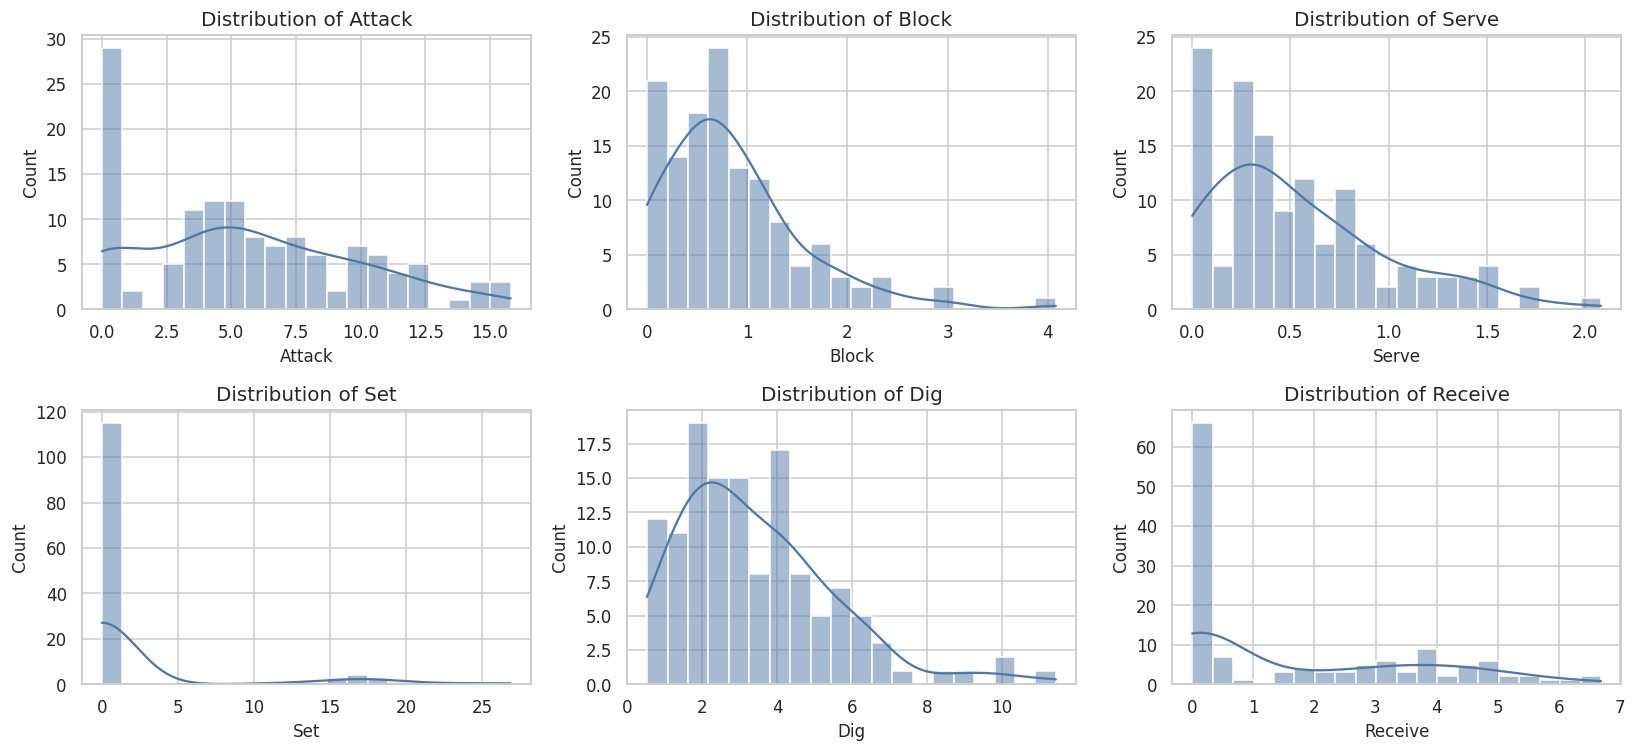

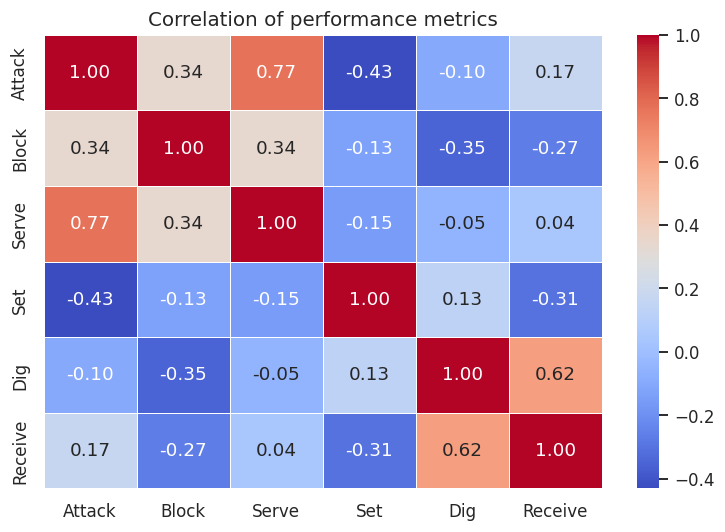

,Attack,Block,Serve,Set,Dig,Receive
Country,,,,,,
France,6.670000,0.908000,0.501000,1.741000,3.859000,1.810000
Japan,6.595000,0.551250,0.641250,2.492500,4.047500,2.042500
Cuba,6.344286,0.965714,0.558571,2.178571,2.894286,1.655714
Serbia,5.998750,1.037500,0.565000,2.093750,3.830000,1.801250
Italy,5.965000,1.261250,0.755000,3.147500,4.486250,1.741250
Slovenia,5.961250,0.846250,0.500000,2.143750,4.231250,2.336250
Argentina,5.925000,1.060000,0.535000,3.361250,4.235000,2.036250
Nederland,5.880000,0.774286,0.701429,2.440000,3.120000,1.631429
Poland,5.807000,0.818000,0.582000,1.800000,3.256000,1.568000


,Attack,Block,Serve,Set,Dig,Receive
Position,,,,,,
L,0.000000,0.000000,0.000000,0.000000,7.098125,3.839375
Mb,4.544688,1.525625,0.474687,0.002500,1.531250,0.176250
Oh,8.381667,0.795952,0.709524,0.022143,3.581667,3.487143
Op,9.326000,0.783600,0.802400,0.006000,2.921200,0.277200
S,0.536250,0.558125,0.321250,17.879375,3.943125,0.010625


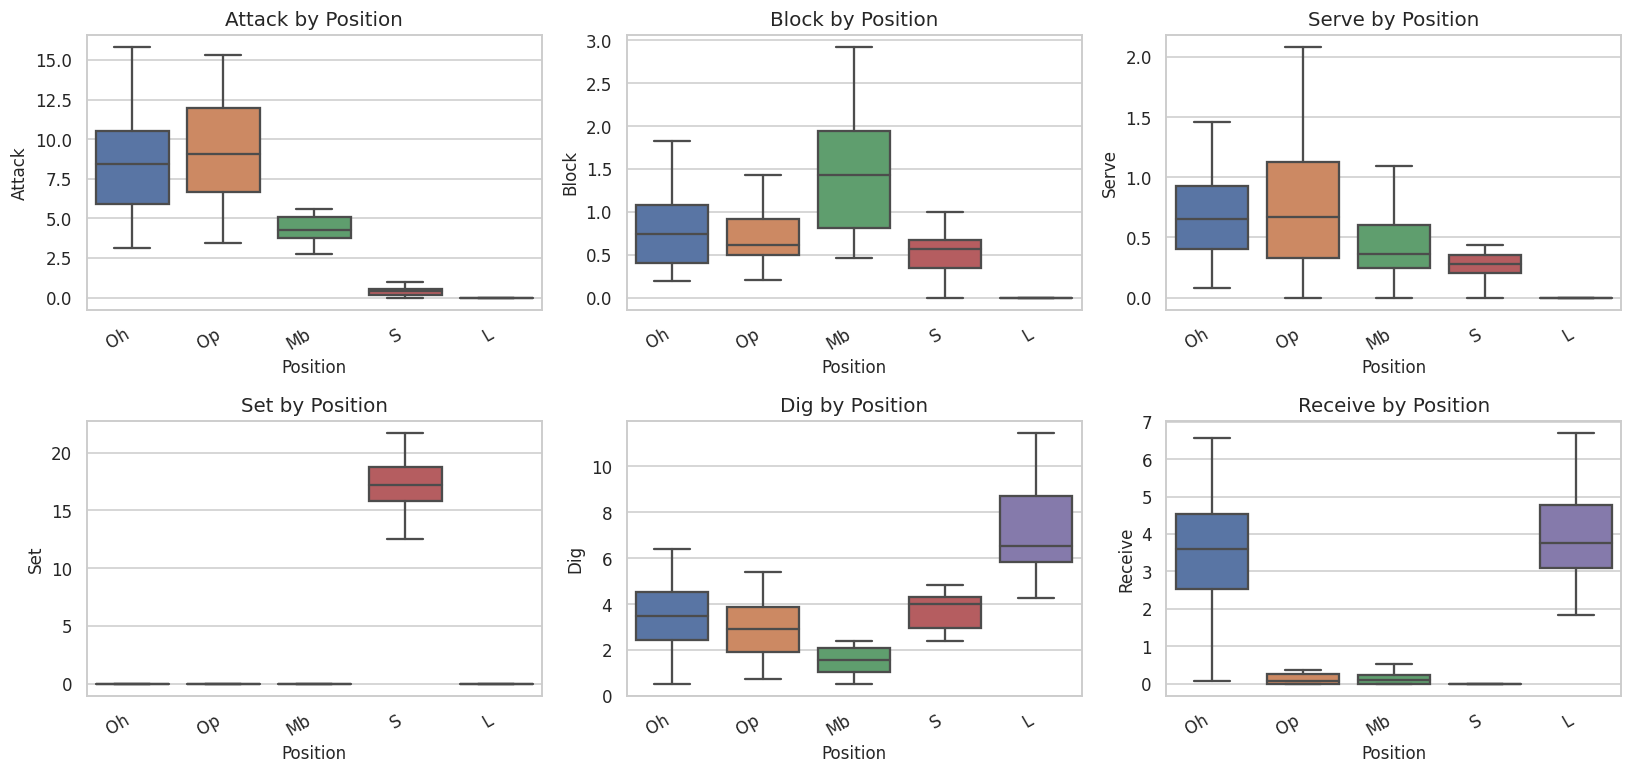

In [21]:
# Step 3: Exploratory data analysis (cleaned data)
metrics = [c for c in ["Attack", "Block", "Serve", "Set", "Dig", "Receive"] if c in df_clean.columns]

print("Unique positions:", sorted(df_clean["Position"].dropna().unique()) if "Position" in df_clean.columns else "N/A")
print("Unique countries:", len(df_clean["Country"].dropna().unique()) if "Country" in df_clean.columns else "N/A")

display(df_clean.describe(include="all"))

if metrics:
    n = len(metrics)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(5 * ncols, 3.5 * nrows))
    for i, col in enumerate(metrics, start=1):
        plt.subplot(nrows, ncols, i)
        sns.histplot(df_clean[col], bins=20, kde=True, color="#4e79a7")
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
    plt.tight_layout()
    plt.show()

    corr = df_clean[metrics].corr()
    plt.figure(figsize=(7, 5))
    sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation of performance metrics")
    plt.tight_layout()
    plt.show()

if "Country" in df_clean.columns and metrics:
    country_means = df_clean.groupby("Country")[metrics].mean().sort_values(metrics[0], ascending=False)
    display(country_means.head(10))

if "Position" in df_clean.columns and metrics:
    position_means = df_clean.groupby("Position")[metrics].mean()
    display(position_means)

    n = len(metrics)
    ncols = 3
    nrows = (n + ncols - 1) // ncols
    plt.figure(figsize=(5 * ncols, 3.6 * nrows))
    for i, col in enumerate(metrics, start=1):
        plt.subplot(nrows, ncols, i)
        sns.boxplot(data=df_clean, x="Position", y=col, showfliers=False)
        plt.title(f"{col} by Position")
        plt.xticks(rotation=30, ha="right")
        plt.xlabel("Position")
        plt.ylabel(col)
    plt.tight_layout()
    plt.show()


Top 15 Player by Attack


,Player,Country,Position,Attack
0,Ichikawa Yuki,Japan,Oh,15.80
1,Abdel-Aziz Nimir,Nederland,Op,15.33
2,Faure Theo,France,Op,15.25
3,Herrera Jaime Jesus,Cuba,Op,15.00
4,Luburic Drazen,Serbia,Op,14.33
5,Nikolov Aleksandar,Bulgaria,Oh,14.25
6,Zhang Jingyin,China,Oh,13.50
7,Urnaut Tine,Slovenia,Oh,12.62
8,Souza Alen,Brazil,Op,12.46
9,Lopez Castro Miguel Angel,Cuba,Oh,12.33


Top 15 Player by Block


,Player,Country,Position,Block
0,Loser Agustin,Argentina,Mb,4.08
1,Faure Theo,France,Op,3.00
2,Mousavi Seyed Mohammad,Iran,Mb,2.92
3,Concepcion Rojas Javier Octavio,Cuba,Mb,2.42
4,Krsmanovic Petar,Serbia,Mb,2.42
5,Nedeljkovic Aleksandar,Serbia,Mb,2.42
6,Russo Roberto,Italy,Mb,2.18
7,Plak Fabian,Nederland,Mb,2.08
8,Galassi Gianluca,Italy,Mb,2.00
9,Grozdenov Aleks,Bulgaria,Mb,1.92


Top 15 Player by Serve


,Player,Country,Position,Serve
0,Abdel-Aziz Nimir,Nederland,Op,2.08
1,Herrera Jaime Jesus,Cuba,Op,1.75
2,Esmaeilnezhad Amin,Iran,Op,1.75
3,Faure Theo,France,Op,1.50
4,Romano Yuri,Italy,Op,1.47
5,Souza Ricardo Lucarelli,Brazil,Oh,1.46
6,Palonsky Luciano,Argentina,Oh,1.46
7,Zhang Jingyin,China,Oh,1.42
8,Ichikawa Yuki,Japan,Oh,1.40
9,Urnaut Tine,Slovenia,Oh,1.38


Top 15 Player by Set


,Player,Country,Position,Set
0,De Cecco Luciano,Argentina,S,26.89
1,Giannelli Simone,Italy,S,25.18
2,Christenson Micah,Usa,S,21.67
3,Sekita Masahiro,Japan,S,19.73
4,Rezende Bruno Mossa,Brazil,S,18.38
5,Seganov Georgi,Bulgaria,S,17.92
6,Janusz Marcin,Poland,S,17.86
7,Brizard Antoine,France,S,17.33
8,Ropret Gregor,Slovenia,S,17.15
9,Keemink Wessel,Nederland,S,17.08


Top 15 Player by Dig


,Player,Country,Position,Dig
0,Grebennikov Jenia,France,L,11.44
1,Balaso Fabio,Italy,L,10.00
2,Kovacic Jani,Slovenia,L,9.85
3,Yamamoto Tomohiro,Japan,L,8.73
4,Danani Santiago,Argentina,L,8.69
5,Zatorski Pawel,Poland,L,7.09
6,Andringa Robbert,Nederland,L,6.92
7,Giannelli Simone,Italy,S,6.64
8,Qu Zongshuai,China,L,6.58
9,Kapur Milorad,Serbia,L,6.50


Top 15 Player by Receive


,Player,Country,Position,Receive
0,Kovacic Jani,Slovenia,L,6.69
1,Tillie Kevin,France,Oh,6.56
2,Danani Santiago,Argentina,L,6.15
3,Reichert Moritz,Germany,Oh,5.75
4,Ichikawa Yuki,Japan,Oh,5.60
5,Lavia Daniele,Italy,Oh,5.55
6,Atanasov Martin,Bulgaria,Oh,5.25
7,Takahashi Ran,Japan,Oh,5.07
8,Balaso Fabio,Italy,L,5.00
9,Urnaut Tine,Slovenia,Oh,5.00


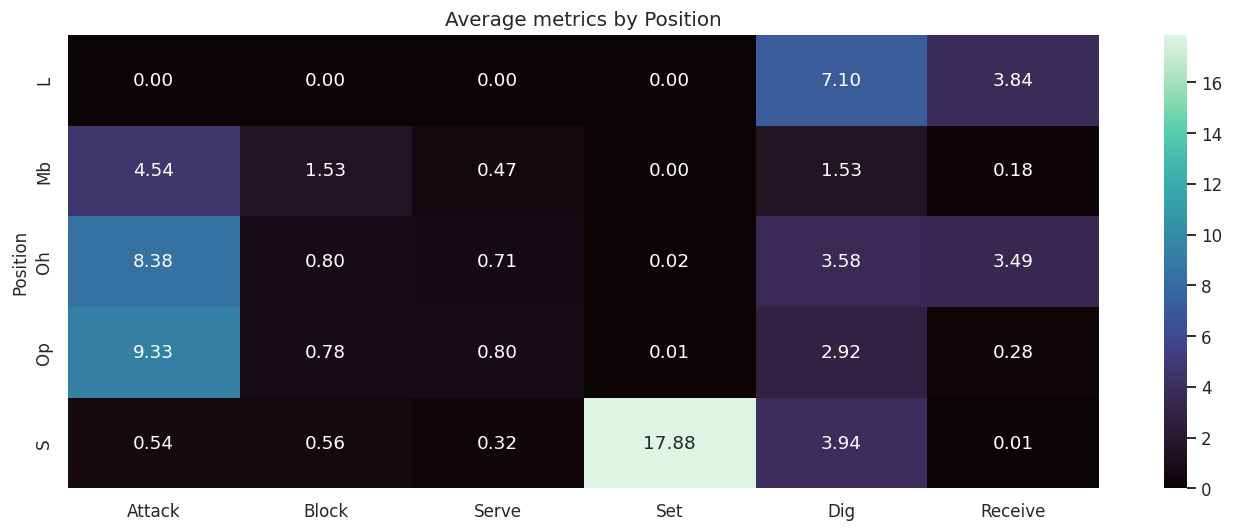

In [22]:
# Step 4: Player drill-downs and positional comparisons
metrics = [c for c in ["Attack", "Block", "Serve", "Set", "Dig", "Receive"] if c in df_clean.columns]

name_cols = [c for c in ["Player", "Name", "Athlete"] if c in df_clean.columns]
player_col = name_cols[0] if name_cols else None


if metrics and player_col:
    TOP_N = 15
    for col in metrics:
        cols_to_show = [player_col, "Country", "Position", col]
        available_cols = [c for c in cols_to_show if c in df_clean.columns]
        top_players = (
            df_clean[available_cols]
            .sort_values(col, ascending=False)
            .head(TOP_N)
            .reset_index(drop=True)
        )
        print(f"Top {TOP_N} {player_col} by {col}")
        display(top_players)
else:
    print("Player drill-down skipped (missing player name column).")

if "Position" in df_clean.columns and metrics:
    pos_means = df_clean.groupby("Position")[metrics].mean()
    plt.figure(figsize=(1.6 * len(metrics) + 3, 0.6 * len(pos_means) + 2))
    sns.heatmap(pos_means, annot=True, fmt=".2f", cmap="mako", cbar=True)
    plt.title("Average metrics by Position")
    plt.tight_layout()
    plt.show()



In [26]:
# Step 5: Feature engineering (normalized metrics & composite score)
feature_metrics = [c for c in ["Attack", "Block", "Serve", "Set", "Dig", "Receive"] if c in df_clean.columns]

features_df = df_clean.copy()

z_cols = []
for col in feature_metrics:
    mean = features_df[col].mean()
    std = features_df[col].std(ddof=0)
    z_col = f"z_{col}"
    features_df[z_col] = (features_df[col] - mean) / (std if std and not np.isclose(std, 0.0) else 1.0)
    z_cols.append(z_col)

if z_cols:
    features_df["CompositeScore"] = features_df[z_cols].mean(axis=1)

if "Position" in features_df.columns:
    for col in feature_metrics:
        features_df[f"pos_norm_{col}"] = features_df[col] - features_df.groupby("Position")[col].transform("mean")

print("Feature columns added:", [c for c in features_df.columns if c.startswith("z_") or c.startswith("pos_norm_") or c == "CompositeScore"])
features_df.head()



Feature columns added: ['z_Attack', 'z_Block', 'z_Serve', 'z_Set', 'z_Dig', 'z_Receive', 'CompositeScore', 'pos_norm_Attack', 'pos_norm_Block', 'pos_norm_Serve', 'pos_norm_Set', 'pos_norm_Dig', 'pos_norm_Receive']


,Player,Country,Age,Attack,Block,Serve,Set,Dig,Receive,Position,...,z_Set,z_Dig,z_Receive,CompositeScore,pos_norm_Attack,pos_norm_Block,pos_norm_Serve,pos_norm_Set,pos_norm_Dig,pos_norm_Receive
0,Ichikawa Yuki,Japan,28,15.80,1.13,1.40,0.07,4.80,5.60,Oh,...,-0.353264,0.662649,1.975354,1.166183,7.418333,0.334048,0.690476,0.047857,1.218333,2.112857
1,Romano Yuri,Italy,26,12.33,1.07,1.47,0.00,3.87,0.00,Op,...,-0.364914,0.213347,-0.849606,0.493584,3.004000,0.286400,0.667600,-0.006000,0.948800,-0.277200
2,Abdel-Aziz Nimir,Nederland,31,15.33,0.67,2.08,0.00,3.17,0.25,Op,...,-0.364914,-0.124837,-0.723492,0.705307,6.004000,-0.113600,1.277600,-0.006000,0.248800,-0.027200
3,Herrera Jaime Jesus,Cuba,28,15.00,0.92,1.75,0.00,3.33,0.17,Op,...,-0.364914,-0.047538,-0.763848,0.636651,5.674000,0.136400,0.947600,-0.006000,0.408800,-0.107200
4,Takahashi Ran,Japan,22,11.53,0.67,1.00,0.07,6.40,5.07,Oh,...,-0.353264,1.435642,1.707992,0.825509,3.148333,-0.125952,0.290476,0.047857,2.818333,1.582857


CV accuracy: 0.929 ± 0.051
              precision    recall  f1-score   support

           L       1.00      1.00      1.00         4
          Mb       0.86      0.75      0.80         8
          Oh       1.00      1.00      1.00        11
          Op       0.71      0.83      0.77         6
           S       1.00      1.00      1.00         4

    accuracy                           0.91        33
   macro avg       0.91      0.92      0.91        33
weighted avg       0.91      0.91      0.91        33



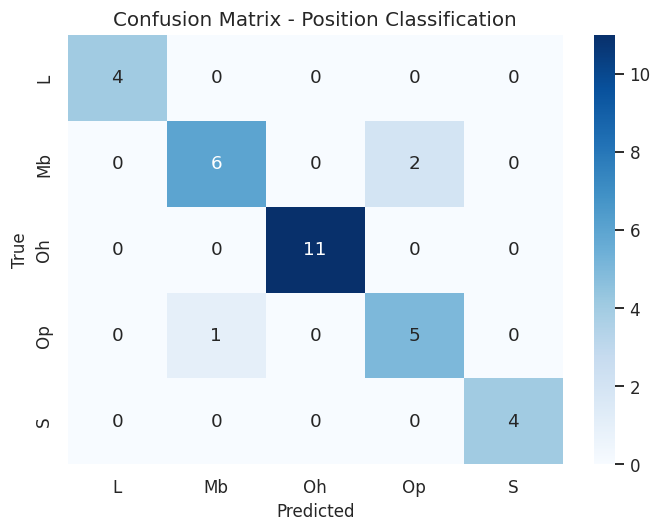

In [27]:
# Step 6: Modeling - predict Position from performance metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

if "Position" not in features_df.columns:
    raise RuntimeError("Position column missing - cannot build classifier.")

numeric_features = [c for c in features_df.columns if c.startswith("z_")]
if not numeric_features:
    numeric_features = [c for c in ["Attack", "Block", "Serve", "Set", "Dig", "Receive"] if c in features_df.columns]

categorical_features = [c for c in ["Country"] if c in features_df.columns]

X = features_df[numeric_features + categorical_features]
y = features_df["Position"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

model = RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1)
clf = Pipeline(steps=[("prep", preprocess), ("model", model)])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
print(f"CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(y.unique()))
plt.figure(figsize=(6.5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(y.unique()), yticklabels=sorted(y.unique()))
plt.title("Confusion Matrix - Position Classification")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



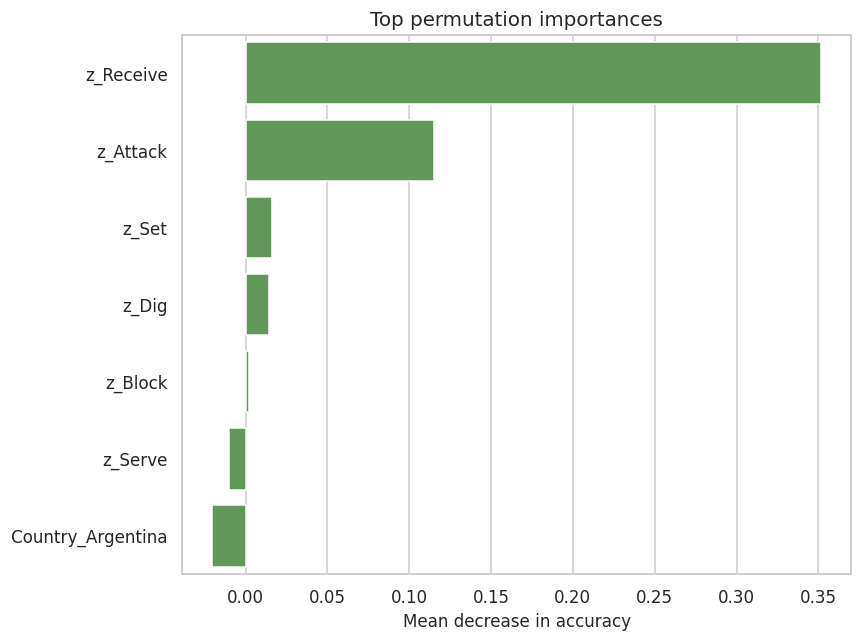

In [29]:
# Step 7: Model interpretation - permutation feature importance
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute permutation importance
result = permutation_importance(
    clf, X_test, y_test, n_repeats=15, random_state=42, n_jobs=-1
)

num_cols = numeric_features
cat_cols = categorical_features

# Get the names of categorical features after one-hot encoding
if cat_cols:
    cat_encoder = clf.named_steps["prep"].named_transformers_["cat"]
    cat_feature_names = cat_encoder.get_feature_names_out(cat_cols).tolist()
else:
    cat_feature_names = []

# Combine numeric and categorical feature names
feature_names = num_cols + cat_feature_names

# Ensure feature_names length matches the number of features used by the model
n_features = len(result.importances_mean)
feature_names_safe = feature_names[:n_features]

# Create a DataFrame with mean and std of importances, sorted by mean
importances = pd.DataFrame({
    "feature": feature_names_safe,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

# Plot the top 15 features by permutation importance
plt.figure(figsize=(8, 6))
sns.barplot(
    data=importances.head(15),
    y="feature",
    x="importance_mean",
    orient="h",
    color="#59a14f",
)
plt.title("Top permutation importances")
plt.xlabel("Mean decrease in accuracy")
plt.ylabel("")
plt.tight_layout()
plt.show()



## Step 8 · Conclusions and Next Steps

- Data cleaned with standardized columns, fixed metric typos, and imputed missing values using position-wise medians.
- EDA visualized metric distributions/correlations and compared countries and positions.
- Engineered z-scores, per-position normalizations, and a composite score for modeling.
- Built a RandomForest + preprocessing pipeline with cross-validated accuracy and held-out confusion matrix.
- Interpreted the model with permutation importance to surface key differentiating skills.

Next steps:
- Try gradient boosting (e.g., XGBoost/LightGBM) and tune hyperparameters.
- Calibrate probabilities and analyze per-class precision/recall.
- Add per-set/per-match rate features if raw attempts/plays are available.
- Perform SHAP-based explanations for deeper interpretation.

